# CMD vs Matching Distance: Strange Attractors

5 chaotic attractors with topologically distinct geometry.

| Class | System | Parameters | Geometry |
|---|---|---|---|
| 0 | Lorenz | $\sigma{=}10,\;\rho{=}28,\;\beta{=}8/3$ | 2 lobes (butterfly) |
| 1 | Rössler | $a{=}0.2,\;b{=}0.2,\;c{=}5.7$ | 1 spiral + fold |
| 2 | Thomas | $b{=}0.208186$ | 3 cyclic lobes ($\mathbb{Z}_3$) |
| 3 | Sprott | $a{=}2.07,\;b{=}1.79$ | Invariant tori |
| 4 | Four-Wing | $a{=}0.2,\;b{=}0.01,\;c{=}{-}0.4$ | 4 symmetric wings |

**Bifiltration**: $\phi_1 = \sqrt{\alpha}$ (Alpha complex filtration on simplices),
$\phi_2 = \text{eccentricity}$ (lower-star extension to simplices).
Both normalized to $[0,1]$ per sample ($\phi_1$ via 99th percentile).

Three distance approximations compared:
- **CMD** (11 convex lines)
- **MD 121** (11×11 folding grid)
- **MD 10** (2×5 folding grid)

Attractor equations from [Ponce Campuzano (2018)](https://www.dynamicmath.xyz/strange-attractors/).

In [1]:
import numpy as np
import gudhi as gd
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import pairwise_distances as pdist_sklearn
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.integrate import solve_ivp
from tqdm import tqdm
import matplotlib.pyplot as plt
import time, warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [ ]:
# --- Dataset ---
n = 500
n_ex = 40
k_neighbors = 15
FUNC1 = 'alpha'        # sqrt of Alpha complex filtration
FUNC2 = 'eccentricity'

# --- CMD (11 convex lines) ---
t_values = np.linspace(0, 1, 11)       # 11 params

# --- MD fine (11x11 folding grid) ---
a_fine = np.linspace(0.05, 0.95, 11)
b_fine = np.linspace(0, 1, 11)          # 121 params

# --- MD coarse (2x5 folding grid) ---
a_coarse = np.array([0.25, 0.75])
b_coarse = np.linspace(0, 1, 5)         # 10 params

BOTTLENECK_E = 0.01
K_KNN = 3
NOISE_LEVELS = [0]

class_names = ['Lorenz', 'Rössler', 'Thomas', 'Sprott', 'Four-Wing']
n_classes = len(class_names)

n_cmd = len(t_values)
n_md_fine = len(a_fine) * len(b_fine)
n_md_coarse = len(a_coarse) * len(b_coarse)
print(f'CMD: {n_cmd} params | MD fine: {n_md_fine} params | MD coarse: {n_md_coarse} params')
print(f'Noise levels: {NOISE_LEVELS}')

CMD: 11 params | MD fine: 121 params | MD coarse: 10 params
Noise levels: [0.06]


## Dataset Generation

In [3]:
# --- ODE right-hand sides ---

def lorenz_rhs(t, s):
    x, y, z = s
    sigma, rho, beta = 10.0, 28.0, 8.0/3.0
    return [sigma*(y - x), x*(rho - z) - y, x*y - beta*z]

def rossler_rhs(t, s):
    x, y, z = s
    a, b, c = 0.2, 0.2, 5.7
    return [-(y + z), x + a*y, b + z*(x - c)]

def thomas_rhs(t, s):
    x, y, z = s
    b = 0.208186
    return [np.sin(y) - b*x, np.sin(z) - b*y, np.sin(x) - b*z]

def sprott_rhs(t, s):
    x, y, z = s
    a, b = 2.07, 1.79
    return [y + a*x*y + x*z, 1.0 - b*x**2 + y*z, x - x**2 - y**2]

def fourwing_rhs(t, s):
    x, y, z = s
    a, b, c = 0.2, 0.01, -0.4
    return [a*x + y*z, b*x + c*y - x*z, -z - x*y]


# (rhs, t_burn, t_run, x0_scale)
attractor_configs = [
    (lorenz_rhs,   20,  100, 5.0),
    (rossler_rhs,  50,  200, 1.0),
    (thomas_rhs,  100,  500, 1.0),
    (sprott_rhs,   50,  200, 0.5),
    (fourwing_rhs, 50,  300, 0.1),
]


def generate_attractor(cls_idx, n_pts=500, noise=0.0, seed=None):
    """Integrate a chaotic ODE and return n_pts subsampled 3D points."""
    rhs, t_burn, t_run, x0_scale = attractor_configs[cls_idx]
    rng = np.random.RandomState(seed)
    x0 = rng.uniform(-x0_scale, x0_scale, 3)

    # burn-in
    sol0 = solve_ivp(rhs, [0, t_burn], x0,
                     rtol=1e-8, atol=1e-8, dense_output=True)
    y0 = sol0.y[:, -1]

    # main integration
    n_dense = max(10000, 20*n_pts)
    t_eval = np.linspace(0, t_run, n_dense)
    sol = solve_ivp(rhs, [0, t_run], y0,
                    t_eval=t_eval, rtol=1e-8, atol=1e-8)
    traj = sol.y.T  # (n_dense, 3)

    # subsample uniformly
    idx = np.linspace(0, len(traj)-1, n_pts, dtype=int)
    pts = traj[idx].copy()

    pmin, pmax = pts.min(axis=0), pts.max(axis=0)
    range = pmax - pmin
    range[range < 1e-12] = 1.0
    pts = (pts - pmin) / range

    # additive noise
    if noise > 0:
        pts += rng.normal(0, noise, pts.shape)
    return pts


generators = [lambda n, noise=0.0, c=c: generate_attractor(c, n, noise,
              seed=np.random.randint(0, 10**7))
              for c in range(n_classes)]

## Visualization (noise = 0)

In [4]:
# Generate one example per class at noise=0 for visualization
np.random.seed(0)
viz_data = [generate_attractor(c, n_pts=n, noise=0.0, seed=c)
            for c in range(n_classes)]

# Compute Alpha filtration (sqrt, p99-normalized) and eccentricity
viz_phi1 = []
viz_phi2 = []
for pts in viz_data:
    # phi2 = eccentricity on vertices
    f2_vert = np.max(pdist_sklearn(pts), axis=1)
    f2_vert = (f2_vert - f2_vert.min()) / (f2_vert.max() - f2_vert.min())
    viz_phi2.append(f2_vert)
    # phi1 = Alpha at vertex level is 0, but we show sqrt(alpha) on edges
    # For vertex-level viz, use codensity as proxy
    f1_proxy = NearestNeighbors(n_neighbors=k_neighbors+1).fit(pts).kneighbors(pts)[0][:, -1]
    f1_proxy = (f1_proxy - f1_proxy.min()) / (f1_proxy.max() - f1_proxy.min()) if f1_proxy.max() > f1_proxy.min() else f1_proxy
    viz_phi1.append(f1_proxy)
np.random.seed(42)  # restore

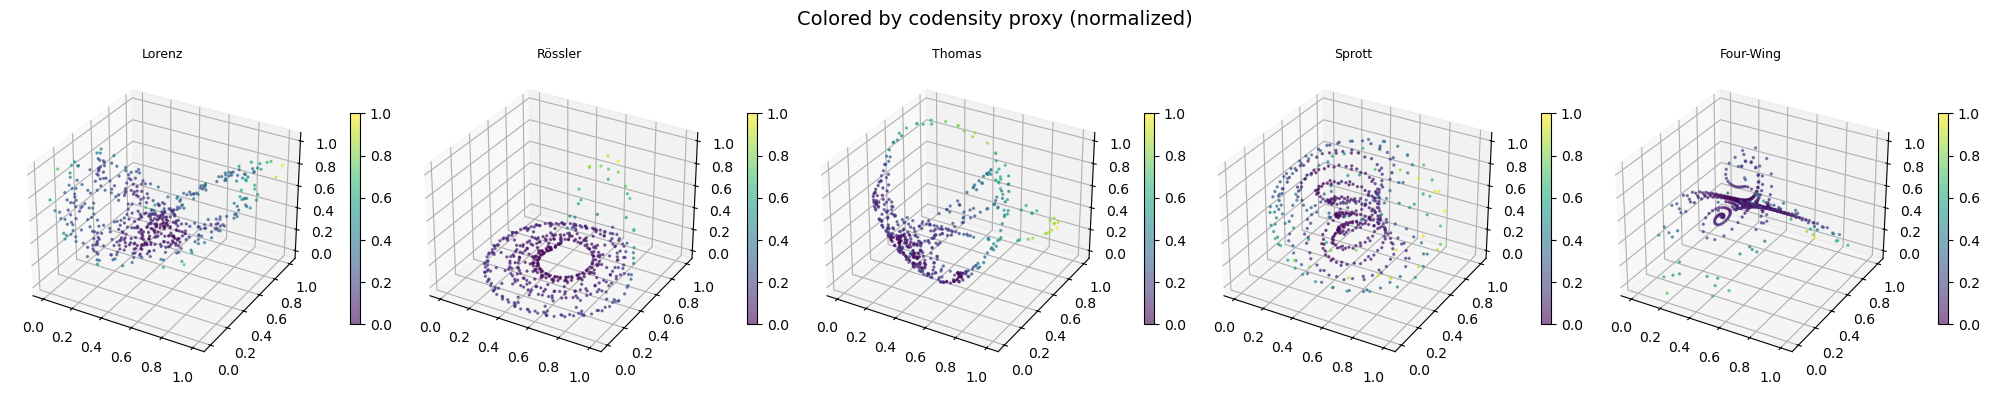

In [5]:
fig = plt.figure(figsize=(20, 4))
for c in range(n_classes):
    ax = fig.add_subplot(1, n_classes, c + 1, projection='3d')
    sc = ax.scatter(viz_data[c][:, 0], viz_data[c][:, 1], viz_data[c][:, 2],
                    s=2, alpha=0.6, c=viz_phi1[c], cmap='viridis')
    ax.set_title(class_names[c], fontsize=9)
    fig.colorbar(sc, ax=ax, fraction=0.03, pad=0.1)
fig.suptitle('Colored by codensity proxy (normalized)', fontsize=14)
plt.tight_layout()
plt.show()

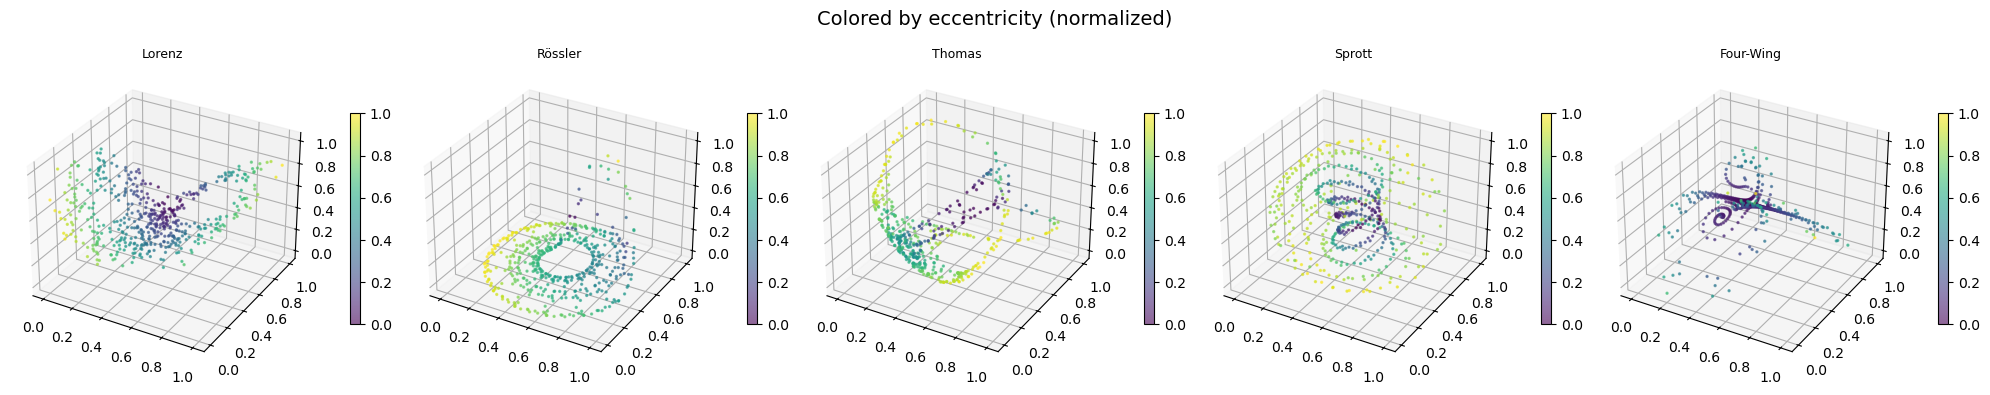

In [6]:
fig = plt.figure(figsize=(20, 4))
for c in range(n_classes):
    ax = fig.add_subplot(1, n_classes, c + 1, projection='3d')
    sc = ax.scatter(viz_data[c][:, 0], viz_data[c][:, 1], viz_data[c][:, 2],
                    s=2, alpha=0.6, c=viz_phi2[c], cmap='viridis')
    ax.set_title(class_names[c], fontsize=9)
    fig.colorbar(sc, ax=ax, fraction=0.03, pad=0.1)
fig.suptitle('Colored by eccentricity (normalized)', fontsize=14)
plt.tight_layout()
plt.show()

## Core Functions

**Key difference from the synthetic shapes notebook**: here $\phi_1$ is the
Alpha complex filtration itself (defined on all simplices, not just vertices).
We read $\sqrt{\alpha(\sigma)}$ for each simplex $\sigma$ and normalize to $[0,1]$
via the 99th percentile.  $\phi_2$ is the lower-star extension of eccentricity
($\phi_2(\sigma) = \max_{v \in \sigma} \text{ecc}(v)$, normalized to $[0,1]$).

The combined filtration for CMD is:
$$g_t(\sigma) = (1-t)\,\phi_1(\sigma) + t\,\phi_2(\sigma)$$

For MD the folding-based filtration $\phi^*_{a,b}$ is applied
simplex-wise in the same way.

In [7]:
def compute_eccentricity(points):
    return np.max(pdist_sklearn(points), axis=1)


class AlphaEccSimplexTree:
    """Alpha complex with bifiltration: sqrt(alpha) + eccentricity.

    Stores per-simplex Alpha filtration values (sqrt, p99-normalized)
    and per-vertex eccentricity (min-max normalized).  Supports
    computing persistence for arbitrary combinations of the two.
    """

    def __init__(self, points, ecc_normalized):
        ac = gd.AlphaComplex(points=points)
        self.st = ac.create_simplex_tree()

        # Read Alpha filtration values and simplex list
        self._simplices = []
        self._alpha = []      # sqrt(alpha) per simplex
        self._ecc_ls = []     # lower-star eccentricity per simplex

        for simplex, filt in self.st.get_filtration():
            s = tuple(simplex)
            self._simplices.append(s)
            self._alpha.append(np.sqrt(max(filt, 0.0)))
            self._ecc_ls.append(max(ecc_normalized[v] for v in s))

        self._alpha = np.array(self._alpha)
        self._ecc_ls = np.array(self._ecc_ls)

        # Clip alpha to max finite H1 death, then normalize to [0,1]
        clip_val = 0.15
        self._alpha = np.minimum(self._alpha, clip_val) / clip_val

    def compute_pd(self, combine_fn):
        """Compute PD for a combined filtration.

        combine_fn(alpha_arr, ecc_arr) -> filt_arr
        where alpha_arr and ecc_arr are arrays over all simplices.
        """
        filt_vals = combine_fn(self._alpha, self._ecc_ls)
        for i, s in enumerate(self._simplices):
            self.st.assign_filtration(list(s), float(filt_vals[i]))
        self.st.make_filtration_non_decreasing()
        self.st.persistence()
        pds = []
        for dim in range(2):
            pd = self.st.persistence_intervals_in_dimension(dim)
            if pd is not None and len(pd) > 0:
                pd = pd[np.isfinite(pd[:, 1])]
            if pd is None or len(pd) == 0:
                pd = np.empty((0, 2))
            pds.append(pd)
        return tuple(pds)


def phi_star_ab_simplex(alpha, ecc, a, b):
    """Matching-distance folding applied simplex-wise."""
    return np.minimum(a, 1-a) * np.maximum((alpha - b)/a, (ecc + b)/(1-a))


def safe_bottleneck(pd1, pd2, e=0.0):
    if len(pd1) == 0 and len(pd2) == 0: return 0.0
    if len(pd1) == 0: return float(np.max((pd2[:,1]-pd2[:,0])/2))
    if len(pd2) == 0: return float(np.max((pd1[:,1]-pd1[:,0])/2))
    return gd.bottleneck_distance(pd1, pd2, e)

In [8]:
def precompute_pds(Data, Ecc_norm, params_list):
    """Precompute PDs for all samples and all methods.

    params_list: list of (name, make_combine_fns)
      where make_combine_fns() returns a list of combine_fn callables.
    """
    N = len(Data)
    PDs = {name: [None]*N for name, _ in params_list}
    for i in tqdm(range(N), desc='  PDs'):
        aest = AlphaEccSimplexTree(Data[i], Ecc_norm[i])
        for name, make_fns in params_list:
            PDs[name][i] = [aest.compute_pd(fn) for fn in make_fns()]
    return PDs


def compute_distance_matrices(PDs, indices, n_params, e=0.0):
    m = len(indices)
    D_H0 = np.zeros((m, m))
    D_H1 = np.zeros((m, m))
    for i in tqdm(range(m), desc='  Distances', leave=False):
        for j in range(i+1, m):
            max_d0 = max_d1 = 0.0
            ii, jj = indices[i], indices[j]
            for p in range(n_params):
                d0 = safe_bottleneck(PDs[ii][p][0], PDs[jj][p][0], e)
                d1 = safe_bottleneck(PDs[ii][p][1], PDs[jj][p][1], e)
                if d0 > max_d0: max_d0 = d0
                if d1 > max_d1: max_d1 = d1
            D_H0[i,j] = D_H0[j,i] = max_d0
            D_H1[i,j] = D_H1[j,i] = max_d1
    return D_H0, D_H1


def extract_distance_blocks(D_full, train_idx, test_idx):
    return D_full[np.ix_(train_idx, train_idx)], D_full[np.ix_(test_idx, train_idx)]


def classify_knn_most_confident(D_train_list, D_test_list,
                                labels_train, labels_test, k=3):
    labels_train = np.asarray(labels_train)
    labels_test = np.asarray(labels_test)
    n_degrees = len(D_train_list)
    n_test = D_test_list[0].shape[0]
    final = np.zeros(n_test, dtype=int)
    for i in range(n_test):
        best_conf, best_pred, best_dist = -1.0, 0, np.inf
        for d in range(n_degrees):
            dists_i = D_test_list[d][i]
            k_nearest = np.argsort(dists_i)[:k]
            nn_labels = labels_train[k_nearest]
            pred = Counter(nn_labels).most_common(1)[0][0]
            conf = np.sum(nn_labels == pred) / k
            avg_d = np.mean(dists_i[k_nearest])
            if conf > best_conf or (conf == best_conf and avg_d < best_dist):
                best_conf, best_pred, best_dist = conf, pred, avg_d
        final[i] = best_pred
    return float(np.mean(final == labels_test))

## Run Experiments

In [9]:
def make_cmd_fns():
    """CMD: convex combination (1-t)*alpha + t*ecc for each t."""
    return [lambda a, e, t=t: (1-t)*a + t*e for t in t_values]

def make_md_fine_fns():
    """MD fine: folding phi*_{a,b} for each (a,b) on 11x11 grid."""
    return [lambda al, ec, a=a, b=b: phi_star_ab_simplex(al, ec, a, b)
            for a in a_fine for b in b_fine]

def make_md_coarse_fns():
    """MD coarse: folding phi*_{a,b} for each (a,b) on 2x5 grid."""
    return [lambda al, ec, a=a, b=b: phi_star_ab_simplex(al, ec, a, b)
            for a in a_coarse for b in b_coarse]


def run_experiment(noise):
    """Full pipeline for a given noise level."""
    # Generate data
    Data, Labels = [], []
    for cls_idx in range(n_classes):
        for j in range(n_ex):
            Labels.append(cls_idx)
            Data.append(generate_attractor(cls_idx, n_pts=n,
                                           noise=noise,
                                           seed=42 + cls_idx*1000 + j))
    Labels = np.array(Labels)
    N = len(Data)

    # Eccentricity (normalized to [0,1] per sample)
    Ecc_norm = []
    for data in Data:
        e = compute_eccentricity(data)
        emin, emax = e.min(), e.max()
        if emax > emin:
            e = (e - emin) / (emax - emin)
        Ecc_norm.append(e)

    # Precompute all PDs
    params = [('cmd', make_cmd_fns),
              ('mdf', make_md_fine_fns),
              ('mdc', make_md_coarse_fns)]
    t0 = time.time()
    PDs = precompute_pds(Data, Ecc_norm, params)
    time_pds = time.time() - t0

    # Distance matrices
    all_idx = list(range(N))
    method_cfg = [
        ('cmd', n_cmd),
        ('mdf', n_md_fine),
        ('mdc', n_md_coarse),
    ]
    Ds = {}
    times_dist = {}
    for mname, nparam in method_cfg:
        t0 = time.time()
        D0, D1 = compute_distance_matrices(PDs[mname], all_idx, nparam, BOTTLENECK_E)
        times_dist[mname] = time.time() - t0
        Ds[mname] = (D0, D1)

    # 10-fold CV
    accs = {m: [] for m in ['cmd', 'mdf', 'mdc']}
    for fold in range(10):
        idx_tr, idx_te, lab_tr, lab_te = train_test_split(
            np.arange(N), Labels, train_size=0.7, stratify=Labels, random_state=42+fold)
        for mname in accs:
            D0, D1 = Ds[mname]
            blocks = [extract_distance_blocks(D, idx_tr, idx_te) for D in [D0, D1]]
            accs[mname].append(classify_knn_most_confident(
                [b[0] for b in blocks], [b[1] for b in blocks],
                lab_tr, lab_te, K_KNN))

    return accs, times_dist, time_pds

In [10]:
all_results = {}
all_times = {}

for noise in NOISE_LEVELS:
    print(f'\n{"="*60}')
    print(f'NOISE = {noise}')
    print(f'{"="*60}')
    t_total = time.time()
    accs, times_dist, time_pds = run_experiment(noise)
    t_total = time.time() - t_total
    all_results[noise] = accs
    all_times[noise] = {'pds': time_pds, 'dist': times_dist, 'total': t_total}
    for m, lbl in [('cmd','CMD'), ('mdf','MD 121'), ('mdc','MD 10')]:
        print(f'  {lbl:>6}: {np.mean(accs[m]):.2%} ± {np.std(accs[m]):.2%}')
    print(f'  time: {t_total:.0f}s')


NOISE = 0.06


  PDs: 100%|██████████| 200/200 [05:11<00:00,  1.56s/it]
                                                              

     CMD: 81.50% ± 3.29%
  MD 121: 81.83% ± 6.12%
   MD 10: 79.00% ± 5.01%
  time: 2767s


## Results

In [11]:
def fmt(v): return f'{np.mean(v):.2%} ± {np.std(v):.2%}'

print('=' * 75)
print(f'{"Noise":<10} {"CMD":<20} {"MD 121":<20} {"MD 10":<20}')
print('=' * 75)
for noise in NOISE_LEVELS:
    r = all_results[noise]
    print(f'{noise:<10.2f} {fmt(r["cmd"]):<20} {fmt(r["mdf"]):<20} {fmt(r["mdc"]):<20}')
print('=' * 75)

Noise      CMD                  MD 121               MD 10               
0.06       81.50% ± 3.29%       81.83% ± 6.12%       79.00% ± 5.01%      


In [12]:
np.save(f'Attractors_{n:03d}.npy', all_results)

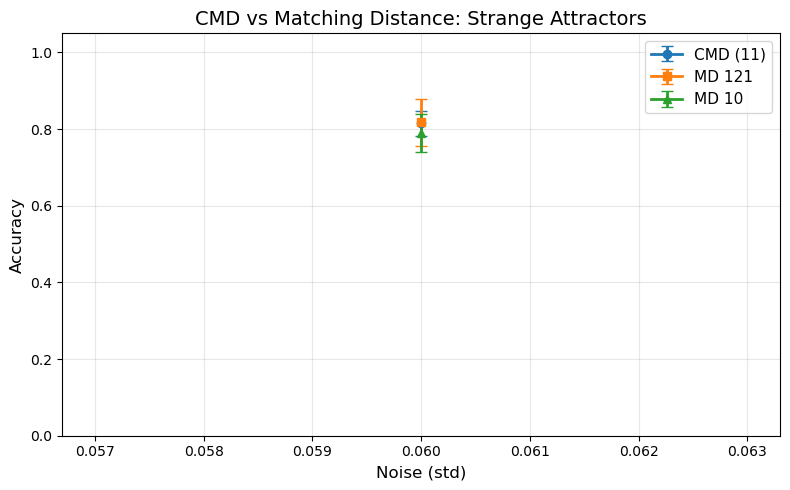

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))

for m, lbl, marker in [('cmd', 'CMD (11)', 'o'),
                        ('mdf', 'MD 121', 's'),
                        ('mdc', 'MD 10', '^')]:
    means = [np.mean(all_results[nl][m]) for nl in NOISE_LEVELS]
    stds  = [np.std(all_results[nl][m]) for nl in NOISE_LEVELS]
    ax.errorbar(NOISE_LEVELS, means, yerr=stds,
                marker=marker, capsize=4, label=lbl, linewidth=2)

ax.set_xlabel('Noise (std)', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('CMD vs Matching Distance: Strange Attractors', fontsize=14)
ax.legend(fontsize=11)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()